# **Task 3: Pre-trained models: pointclouds**

In [8]:
# necessary imports
import os
import glob
import numpy
import pandas
import random
import trimesh
import logging
import tensorflow
from tensorflow.keras import models, layers, regularizers, optimizers, initializers, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, ReLU

# import Stratified K-Fold Cross Validation notebook
%run KFold-Cross-Validation.ipynb

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# number of classes for the classification task
NUM_CLASSES = 5

In [9]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Input Target Size

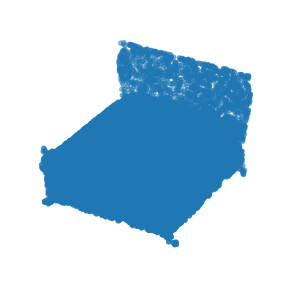

In [10]:
example_path = os.path.join(DATASET_PATH, 'Bed/pointclouds', '1a8e293609eca3b3f7e27638e63d848.obj')
example_obj_file = glob.glob(example_path)
example_mesh = trimesh.load(example_obj_file[0], force='mesh')
points = example_mesh.sample(16384)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
#plt.savefig('imgs/example-mesh-resolution-16384.jpg', dpi=200)
plt.show()

In [11]:
# target size
TARGET_SIZE = 16384

# **PointNet**

In [12]:
# COMMENT ME
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# COMMENT ME
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# COMMENT ME
class OrthogonalRegularizer(regularizers.Regularizer):
    def __init__(self, num_features, l2=0.001):
        self.num_features = num_features
        self.eye = tensorflow.eye(num_features)
        self.l2 = l2

    def __call__(self, x):
        x = tensorflow.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tensorflow.tensordot(x, x, axes=(2, 2))
        xxt = tensorflow.reshape(xxt, (-1, self.num_features, self.num_features))
        return tensorflow.reduce_sum(self.l2 * tensorflow.square(xxt - self.eye))
    
    def get_config(self):
        return {'l2': float(self.l2), 'num_features': int(self.num_features)}

# COMMENT ME
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = tensorflow.keras.initializers.Constant(numpy.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Experiment 1: Base PointNet implementation and training parameters

#### | **Sampling:** 2048 | **Optimizer:** Adam | **Learning Rate:** 0.001 | **LR Decay:** 1e-6 | **Batch size:** 32 | **Epochs:** 300 | **NO Early Stopping** |

In [13]:
# lower target size
TARGET_SIZE = 2048

Found 197 validated pointcloud filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 3111 validated pointcloud filenames belonging to 5 classes.
Found 623 validated pointcloud filenames belonging to 5 classes.
Model: "PointNet-1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                         

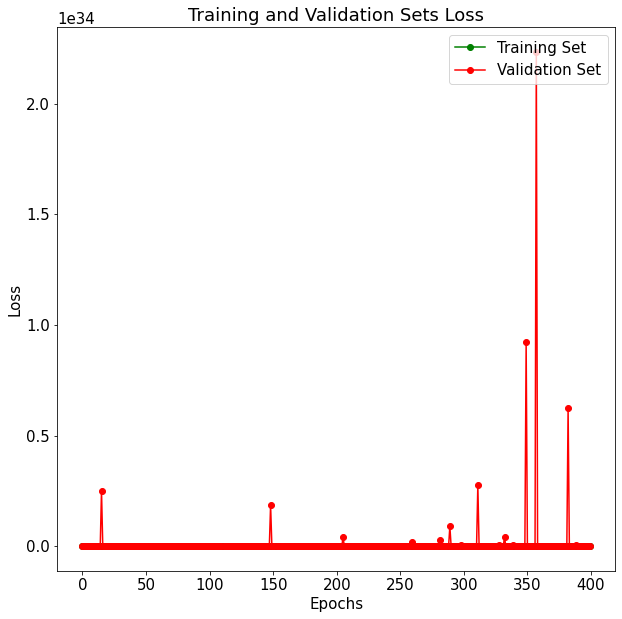

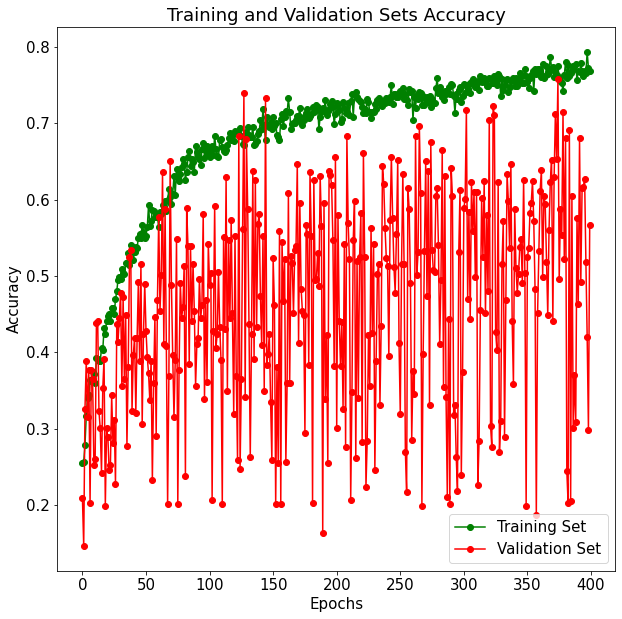

7/7 [==============================] - 0s 12ms/step - loss: 1079668746020383398150799360.0000 - sparse_categorical_accuracy: 0.5279
Best model Test Loss: 1.0796687460203834e+27
Best model Test Accuracy: 0.5279187560081482
Confusion Matrix
Normalized confusion matrix


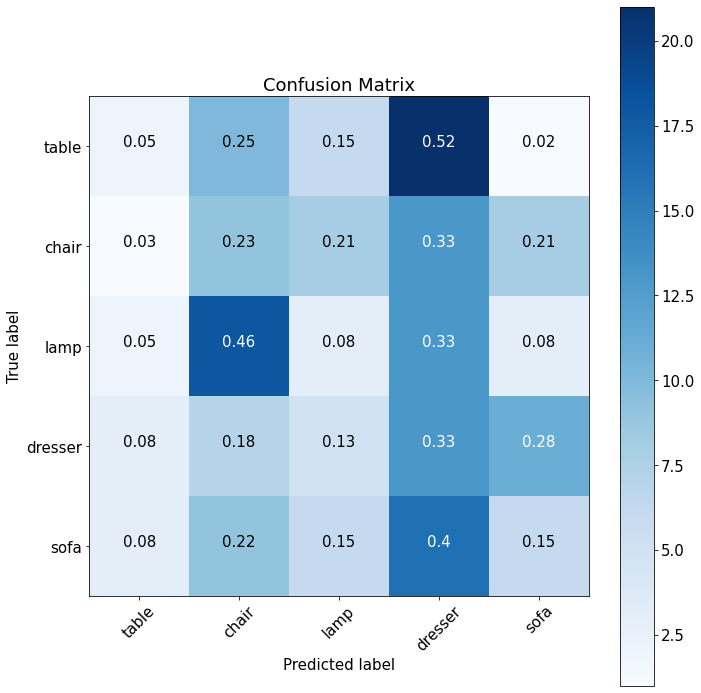

Classification Report
              precision    recall  f1-score   support

       table       0.18      0.05      0.08        40
       chair       0.17      0.23      0.20        39
        lamp       0.11      0.08      0.09        39
     dresser       0.17      0.33      0.23        39
        sofa       0.21      0.15      0.17        40

    accuracy                           0.17       197
   macro avg       0.17      0.17      0.15       197
weighted avg       0.17      0.17      0.15       197


-------- TERMINATED FOLD: 1 --------


In [16]:
# define model to be trained and tested
inputs = Input(shape=(TARGET_SIZE, 3))

# layers
x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

# output softmax classifier
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# define model
model = Model(inputs=inputs, outputs=outputs, name="PointNet-1")

# train, validate and test
pointclouds_kfold_validation_model(model_name="PointNet-1", n_splits=6, test_size=0.05,
                        shuffle=True, model=model, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=400,
                        batch_size=32, one_fold=True, resample_data=0, augment=False)